## Tests statistiques

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats as st

from mylib.descstats import Univa
from mylib.descstats import Biva

In [2]:
# Dataframe import
with open('data/part2.pkl', 'rb') as f:
    my_unpickler = pickle.Unpickler(f)
    main_df = my_unpickler.load()

In [3]:
main_df.head()

,pop_evol_ratio,kcal_total_capita_day,proteins_total_capita_day,proteins_animal_ratio,cluster,F1
country,,,,,,
Arménie,-0.019433,2924.0,90.06,0.480235,Autre,0.834075
Afghanistan,0.321682,2087.0,58.26,0.209749,Afrique,-2.642689
Albanie,-0.020377,3188.0,111.37,0.533537,Occident,1.967446
Algérie,0.188013,3293.0,91.92,0.271867,Moyen Orient,0.311234
Angola,0.392387,2474.0,57.27,0.321285,Afrique,-1.937447


---

Afin de vérifier que nos clusters sont pertinents, nous allons vérifier que la variance inter-classe et la variance intra-classe sont réellement significatives sur une variable la plus gaussienne possible.

Commençons par regarder la distribution de chacune de nos variables.

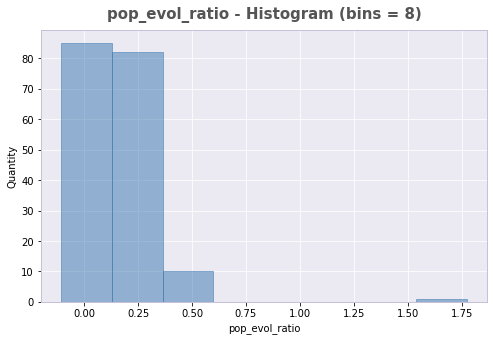

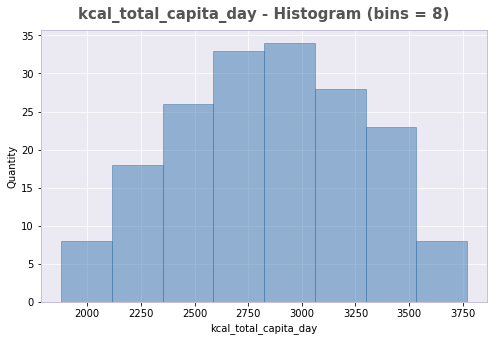

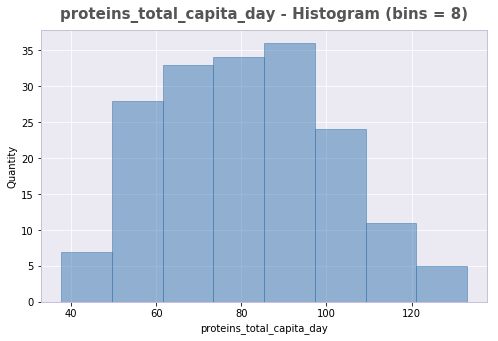

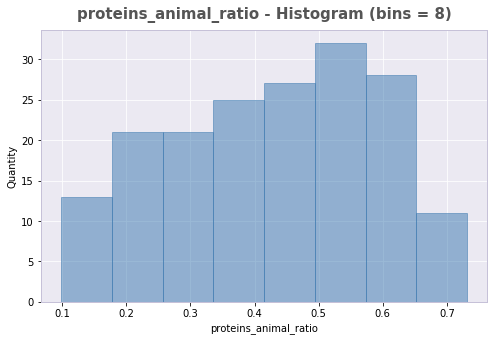

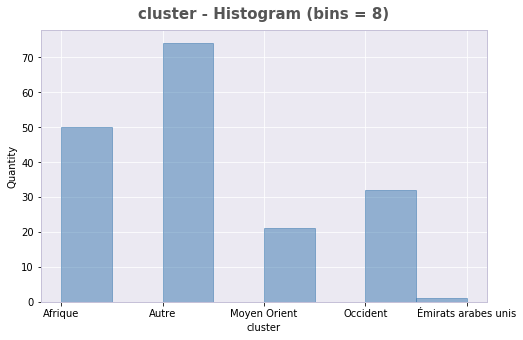

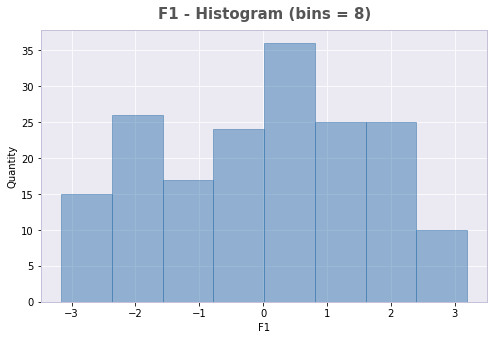

In [4]:
for column in main_df.columns:
    my_univa = Univa(main_df[column])
    my_univa.distribution()

## Recherche d'une variable gaussienne

Nous partons de l'hypothèse nulle H0 que nos variables sont gaussiennes. Notre hypothèse alternative étant que la variable n'est pas gaussienne.

Nous fixons notre seuil de risque à 1%, afin de ne pas rejeter trop facilement les variables candidates.

In [5]:
alpha = 0.01
test_df = main_df.drop('cluster', axis=1)

for var in test_df.columns:
    k2, p = st.normaltest(test_df[var])
    
    if (p > alpha):
        print(f"{var} : Hypothèse nulle non rejetée. (p-value = {p:.4f})")
    else:
        print(f"{var} : Hypothèse nulle rejetée. (p-value = {p:.4f})")

pop_evol_ratio : Hypothèse nulle rejetée. (p-value = 0.0000)
kcal_total_capita_day : Hypothèse nulle rejetée. (p-value = 0.0018)
proteins_total_capita_day : Hypothèse nulle non rejetée. (p-value = 0.0442)
proteins_animal_ratio : Hypothèse nulle rejetée. (p-value = 0.0000)
F1 : Hypothèse nulle rejetée. (p-value = 0.0000)


## Interprétation

Finalement, la seule variable pour laquelle nous ne rejetons pas l'hypothèse nulle au seuil de 1% est "proteins_total_capita_day".

---

## Anova

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


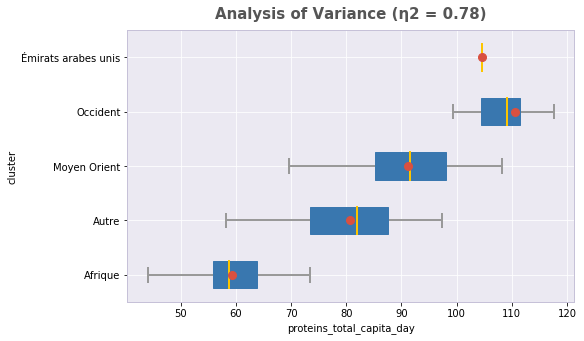

In [6]:
clusters = main_df['cluster']
proteins = main_df['proteins_total_capita_day']

proteins = Biva(clusters, proteins, type_x='quali')
proteins.anova()

Testons les deux clusters qui semblent le plus proche graphiquement, à savoir le cluster "Moyen Orient" et le cluster "Autre".

In [7]:
proteins_cluster1 = main_df[main_df['cluster'] == "Moyen Orient"]['proteins_total_capita_day']
proteins_cluster2 = main_df[main_df['cluster'] == "Autre"]['proteins_total_capita_day']

## Test de Fisher - Test d'adéquation de la variance

Vérifions si les variances sont similaires.

Hypothèse nulle : Les variances sont similaires.

Hypothèse alternative : Les variances sont différentes.

Sources :
- https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/hypothesis-testing/f-test/
- https://openclassrooms.com/fr/courses/4525306-initiez-vous-a-la-statistique-inferentielle/5016619-comparez-deux-echantillons-gaussiens-test-de-comparaison
- https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python

On prend la variance la plus grande parmi les deux pour ensuite appeler la méthode .sf() (survival function).
Ceci permet de regarder l'aire restant à droite sous la courbe.

Si on prend la variance plus petite, alors il faudrait regarder l'aire à gauche sous la courbe avec .cdf (cumulative distribution function).

On rejettera H0 à un seuil de 1% (alpha = 0.01)

In [8]:
# Variance et degré de liberté du cluster1
cluster1_var = proteins_cluster1.var()
cluster1_df = len(proteins_cluster1) - 1

# Variance et degré de liberté du cluster2
cluster2_var = proteins_cluster2.var()
cluster2_df = len(proteins_cluster2) - 1

# Sélection de la plus grosse variance, attribution des valeurs et calcul de notre F-stat.
if cluster1_var > cluster2_var:
    s1 = cluster1_var
    dfn = cluster1_df
    s2 = cluster2_var
    dfd = cluster2_df
    F = cluster1_var/cluster2_var
else:
    s1 = cluster2_var
    dfn = cluster2_df
    s2 = cluster1_var
    dfd = cluster1_df    
    F = cluster2_var/cluster1_var

# Création de la distribution
fdistrib = st.f(dfn, dfd)

## On plote la distribution, juste pour voir.

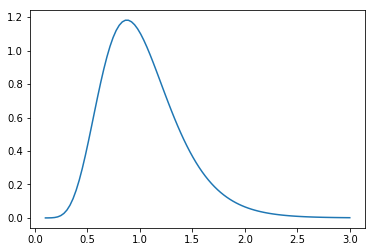

In [9]:
fig, ax = plt.subplots(1,1)
x = np.linspace(0.1, 3, 100)
ax.plot(x, fdistrib.pdf(x))
plt.show()

In [10]:
pvalue = fdistrib.sf(F)
print(f"P-Value : {pvalue}")

P-Value : 0.4140058773427679


L'hypothèse nulle ne peut pas être rejetée, on considère donc les variances similaires.

## Test de Student - Test d'adéquation des moyennes

Vérifions si la moyenne varie significativement entre les deux clusters qui sont visuellement les plus similaires, à savoir le cluster 4 et 5.

Nous rejetterons l'hypothèse nulle à un seuil de 1%.

In [11]:
tstat, pvalue = st.ttest_ind(proteins_cluster1, proteins_cluster2)
print(pvalue)

4.974950500691276e-05


## Interprétation

On peut largement rejeter l'hypothèse nulle au seuil de 1%.

Sur nos deux clusters qui semblent les plus proches, on peut rejetter l'hypothèse nulle d'une moyenne similaire. Ceci confirme la qualité de nos groupes.